**Author**: Steven DiPani

**Project**: Defect Detection in Casting Shells

**Client**: William's International

**Github**: 




<h2>Introduction</h2>

The first and most important part is importing the necessary libraries and resolving dependency issues. This project will not get off the ground if the wrong library versions are used.

In [ ]:
########################
### Import libraries ###
########################

import tensorflow as tf

This part will check if any GPUs are being used. While not necessary, using a GPU shortens the training time tremendously.

Running the block below will output a window such as this

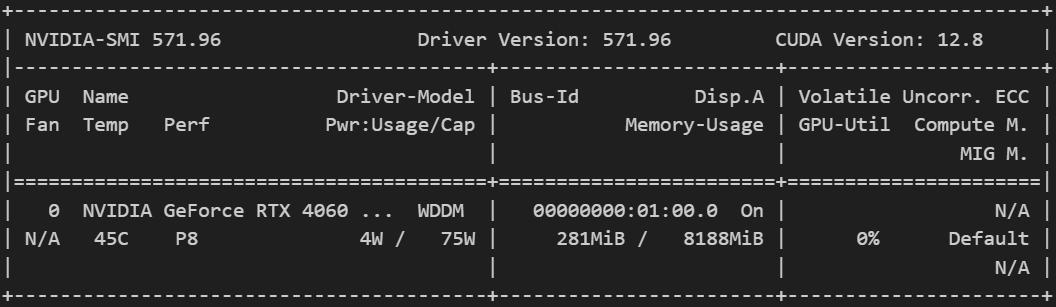

The bottom left box will say which GPUs are available

In [ ]:
#####################################
### Check if machine is using GPU ###
#####################################

!nvidia-smi


<h2> 1. Gather and Label Training Images </h2>

Before training and implementing the model, we need to gather and label the images that will be used for the training. To have a robust model that will work in most environments, the dataset that trains the model needs to be as robust. Below are the recommended number of images necessary for different model implementations. 

Rapid Protoyping: 20-100 images per class

Proof-of-Concept: 100-500 images per class

Small-Scale Model: 500-1000 images per class

Full-Scale Production Model: 1000+ images per class

Generally, the higher the need for precision, the higher the number of images required. For this project, the model will serve as a Proof-of-Concept and will use 50-100 images to train the model. 




<h3> 1.1 Labeling Images </h3>

After the images have been gathered, the following step will be label the images. There are several tools available for labeling images, this project uses *Label Studio*, an open-source labeling tool that has a simple workflow outlined below.

In [ ]:
###########################################
### Check for label-studio installation ###
###########################################

!pip show label-studio

If label-studio is not installed

In [ ]:
############################
### Install label-studio ###
############################

%pip install label-studio

If label-studio is installed

In [ ]:
##########################
### Start label-studio ###
##########################

!label-studio start

<h3> 1.2 Preparing the dataset </h3>

In [ ]:
import zipfile
import os


# Path to your zip file
zip_path = r"D:\Datasets\Dataset2\Dataset2.zip"  # Use raw string (r"") to avoid path issues
extract_to = r"D:\Datasets\Dataset2\Dataset2"   # Destination folder

# Create the destination directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

if(extract_to):
    print("Extraction complete!")

Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

Train: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.
Validation: These images are used to check the model's performance at the end of each training epoch.
In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.

Utilizing a Python script that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder. Run the following code block to download and execute the script.

<h1> 2. Parsing the dataset </h1>

The code below is simply a function we call in the following block. It takes the the dataset and parses it in a way for Ultralytics to understand.

In [ ]:
from pathlib import Path
import random
import os
import sys
import shutil
import argparse

# Define and parse user input arguments
parser = argparse.ArgumentParser()
parser.add_argument('--datapath', help='Path to data folder containing image and annotation files', required=True)
parser.add_argument('--train_pct', help='Ratio of images for training; rest for validation', default=0.8, type=float)
parser.add_argument('--outputpath', help='Output folder for train/validation directories', required=False, default=os.getcwd())

args = parser.parse_args()

data_path = args.datapath
train_percent = float(args.train_pct)
output_path = args.outputpath

# Check for valid entries
if not os.path.isdir(data_path):
   print('Data directory not found. Verify the path and try again.')
   sys.exit(0)

if train_percent < .01 or train_percent > 0.99:
   print('Invalid entry for train_pct. Must be between .01 and .99.')
   sys.exit(0)

# Paths to input images and labels
input_image_path = os.path.join(data_path,'images')
input_label_path = os.path.join(data_path,'labels')

# Define output paths to image and annotation folders
train_img_path = os.path.join(output_path,'data/train/images')
train_txt_path = os.path.join(output_path,'data/train/labels')
val_img_path = os.path.join(output_path,'data/validation/images')
val_txt_path = os.path.join(output_path,'data/validation/labels')

# Create folders if they don't already exist
for dir_path in [train_img_path, train_txt_path, val_img_path, val_txt_path]:
   if not os.path.exists(dir_path):
      os.makedirs(dir_path)
      print(f'Created folder at {dir_path}.')

# Get list of all images and annotation files
img_file_list = [path for path in Path(input_image_path).rglob('*')]
txt_file_list = [path for path in Path(input_label_path).rglob('*')]

print(f'Number of image files: {len(img_file_list)}')
print(f'Number of annotation files: {len(txt_file_list)}')

# Determine number of files to move to each folder
file_num = len(img_file_list)
train_num = int(file_num * train_percent)
val_num = file_num - train_num
print(f'Images moving to train: {train_num}')
print(f'Images moving to validation: {val_num}')

# Select files randomly and copy them to train or val folders
for i, set_num in enumerate([train_num, val_num]):
    for _ in range(set_num):
        img_path = random.choice(img_file_list)
        img_fn = img_path.name
        base_fn = img_path.stem
        txt_fn = base_fn + '.txt'
        txt_path = os.path.join(input_label_path, txt_fn)

        if i == 0: # train set
            new_img_path, new_txt_path = train_img_path, train_txt_path
        else: # validation set
            new_img_path, new_txt_path = val_img_path, val_txt_path

        shutil.copy(img_path, os.path.join(new_img_path, img_fn))
        
        if os.path.exists(txt_path):
            shutil.copy(txt_path, os.path.join(new_txt_path, txt_fn))

        img_file_list.remove(img_path)

In [ ]:
!python "D:\Datasets\train_val_split.py" --datapath="D:\Datasets\Dataset2\Dataset2" --train_pct=0.9 --outputpath="D:\Datasets\Dataset2\Dataset2"

<h1> 3. Install requirements </h1>

In [ ]:
%pip install ultralytics

<h1> 4. Configure training </h1>

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': 'D:\Datasets\Dataset2\Dataset2\data',
      'train': 'D:\\Datasets\\Dataset2\\Dataset2\\data\\train',
      'val': 'D:\\Datasets\\Dataset2\\Dataset2\\data\\validation',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = 'D:\Datasets\Dataset2\Dataset2\classes.txt'
path_to_data_yaml = 'D:\Datasets\Dataset2\Dataset2\data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

<h1> 5. Test model </h1>

In [5]:
import os

data_path = "D:/Datasets/Dataset2/Dataset2/data.yaml"
print(f"Exists: {os.path.exists(data_path)}")
print(f"Readable: {os.access(data_path, os.R_OK)}")

Exists: True
Readable: True


In [ ]:
from ultralytics import YOLO

data_path = r"D:/Datasets/Dataset2/Dataset2/data.yaml"

model = YOLO("yolo11s.pt")

# Test loading the dataset
try:
    model.train(data=data_path, epochs=80, imgsz=480)
except Exception as e:
    print(f"Error: {e}")

<h1> 6. Test model </h1>

In [13]:
import os

source_path = "D:/Datasets/Dataset2/Dataset2/data/validation/images"

print(f"Source exists: {os.path.exists(source_path)}")
print(f"Number of images: {len(os.listdir(source_path))}")

Source exists: True
Number of images: 3


In [27]:
from ultralytics import YOLO

# Load trained model

model = YOLO("C:\\Users\\steve\\OneDrive\\Desktop\\ME 4100\\ML Model Tools\\seniorproject2\\runs\\detect\\train22\\weights\\best.pt")

# Define source path (use forward slashes)
source_path = r"D:/Datasets/Dataset2/Dataset2/data/validation/images"

# Run prediction
results = model.predict(source=source_path, save=True)


image 1/4 D:\Datasets\Dataset2\Dataset2\data\validation\images\4a3793a6-image6.jpg: 384x480 1 testpart, 109.7ms
image 2/4 D:\Datasets\Dataset2\Dataset2\data\validation\images\a1e5a3db-image15.jpg: 384x480 1 testpart, 95.7ms
image 3/4 D:\Datasets\Dataset2\Dataset2\data\validation\images\b32e415d-image9.jpg: 384x480 1 testpart, 113.5ms
image 4/4 D:\Datasets\Dataset2\Dataset2\data\validation\images\test.jpg: 384x480 4 testparts, 103.6ms
Speed: 2.9ms preprocess, 105.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 480)
Results saved to runs\detect\predict2


In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'C:/Users/steve/OneDrive/Desktop/ME 4100/ML Model Tools/seniorproject2/runs/detect/predict2/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')

<h1> 7. Deploy Model </h1>

In [30]:
import os
import shutil
import zipfile

# Define paths
model_dir = r"D:/Datasets/Dataset2/model_ds2"  # Change this path as needed
best_model_src = r"C:/Users/steve/OneDrive/Desktop/ME 4100/ML Model Tools/seniorproject2/runs/detect/train22/weights/best.pt"
best_model_dst = os.path.join(model_dir, "model_ds2.pt")
train_dir_src = r"C:/Users/steve/OneDrive/Desktop/ME 4100/ML Model Tools/seniorproject2/runs/detect/train22"
train_dir_dst = os.path.join(model_dir, "train")
zip_output = f"{model_dir}.zip"  # Output zip file (same location as model_ds2)

# Create the model directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Copy the best.pt model file
shutil.copy(best_model_src, best_model_dst)

# Copy the entire train directory
shutil.copytree(train_dir_src, train_dir_dst, dirs_exist_ok=True)

print("Files copied successfully!")

# Zip the output directory
def zip_directory(folder_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # Store files with relative paths inside the zip
                arcname = os.path.relpath(file_path, start=os.path.dirname(folder_path))
                zipf.write(file_path, arcname)

# Create the zip file
zip_directory(model_dir, zip_output)

print(f"Zipped output saved to: {zip_output}")

Files copied successfully!
Zipped output saved to: D:/Datasets/Dataset2/model_ds2.zip


conda activate yolo-env1
cd C:\Users\steve\OneDrive\Desktop\ME 4100\ML Model Tools\seniorproject2\model_ds2\model_ds2
python yolo_detect.py --model model_ds2.pt --source usb0 --resolution 1280x720